In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import gensim

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,roc_curve,auc
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM
from wordcloud import WordCloud

In [3]:
fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')

In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

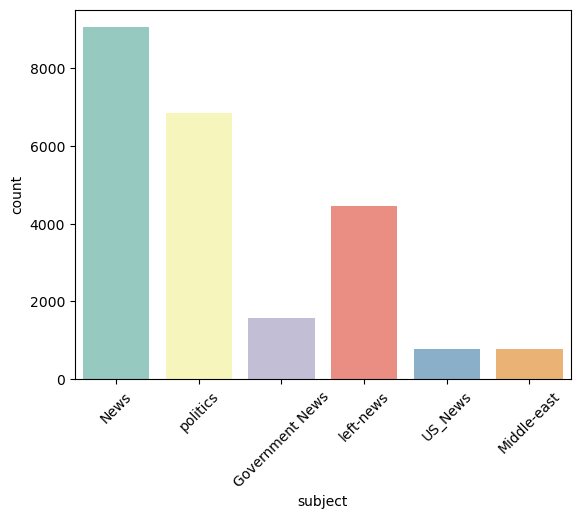

<Figure size 1000x5000 with 0 Axes>

In [7]:
# Distribution of subjects in the fake news dataset
sns.countplot(x='subject',data=fake,palette="Set3")
plt.xticks(rotation=45)
plt.figure(figsize=(10, 50))
plt.show()

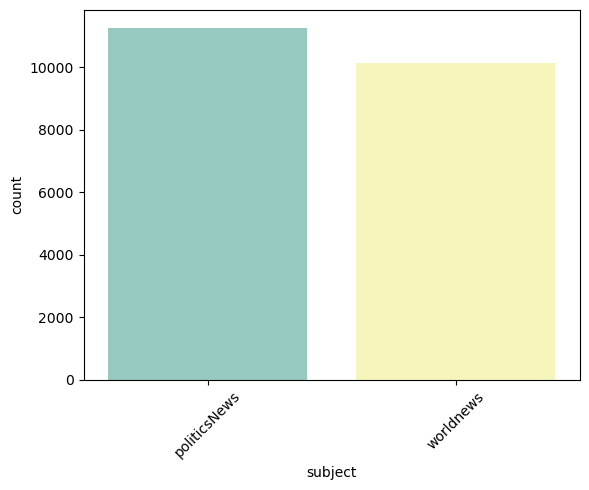

<Figure size 1000x5000 with 0 Axes>

In [8]:
# Distribution of subjects in the true news dataset
sns.countplot(x='subject',data=true,palette="Set3")
plt.xticks(rotation=45)
plt.figure(figsize=(10, 50))
plt.show()

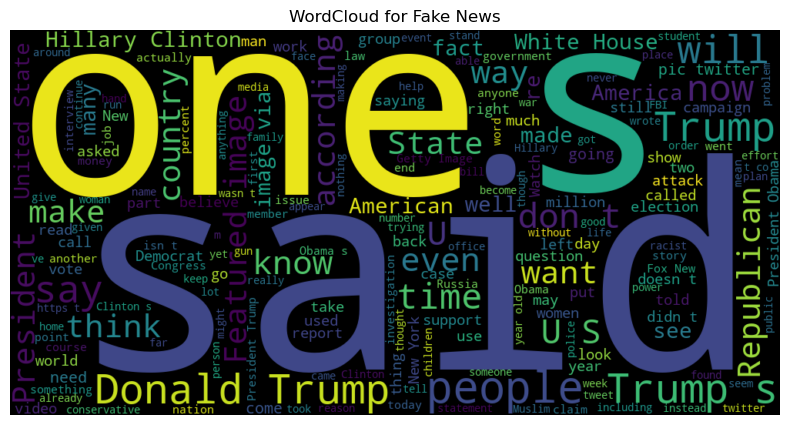

In [9]:
# WordCloud for Fake News
fake_wordcloud = WordCloud(width=1000, height=500).generate(" ".join(fake['text']))
plt.figure(figsize=(10, 5))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Fake News")
plt.show()

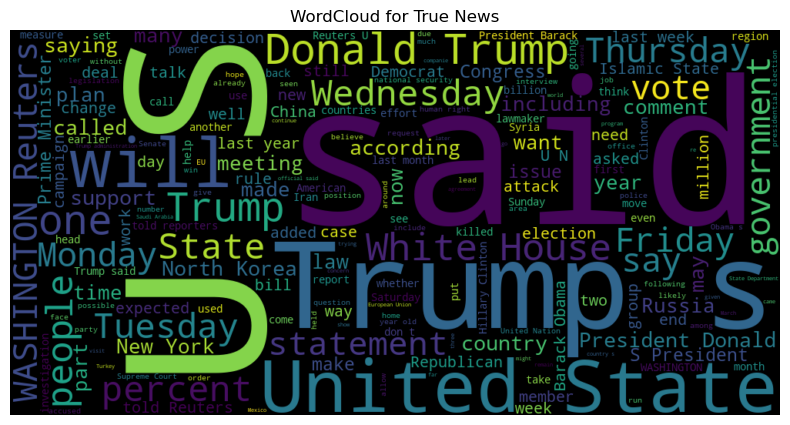

In [10]:
# WordCloud for True News
true_wordcloud = WordCloud(width=1000, height=500).generate(" ".join(true['text']))
plt.figure(figsize=(10, 5))
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for True News")
plt.show()

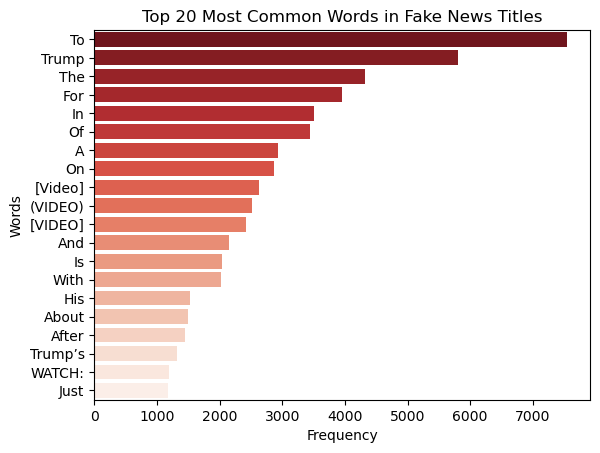

In [11]:
# Most common words in Fake News titles
fake_titles = " ".join(fake['title'])
fake_words = pd.Series(fake_titles.split()).value_counts().head(20)
sns.barplot(y=fake_words.index, x=fake_words.values, palette="Reds_r")
plt.title("Top 20 Most Common Words in Fake News Titles")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

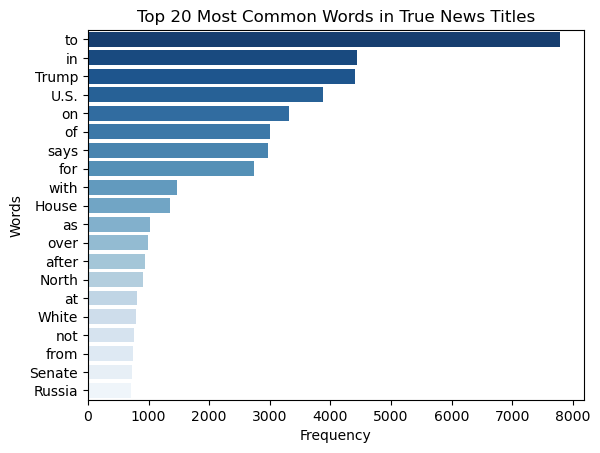

In [12]:
# Most common words in True News titles
true_titles = " ".join(true['title'])
true_words = pd.Series(true_titles.split()).value_counts().head(20)
sns.barplot(y=true_words.index, x=true_words.values, palette="Blues_r")
plt.title("Top 20 Most Common Words in True News Titles")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

In [13]:
def preprocess(df, label):
    df['text'] = (df['title'] + " " + df['text']).str.lower()
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
    df['class'] = label
    return df[['text', 'class']]

In [14]:
data = pd.concat([preprocess(true, 1), preprocess(fake, 0)], ignore_index=True)

##### Tokenization

In [16]:
sentences = data['text'].apply(str.split).tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [17]:
print('\n'.join(f'{key}: {value}' for key, value in list(tokenizer.word_index.items())[:10]))

the: 1
to: 2
of: 3
a: 4
and: 5
in: 6
that: 7
on: 8
for: 9
s: 10


In [18]:
x = pad_sequences(tokenizer.texts_to_sequences(sentences), maxlen=1000)

##### Word2Vec Model and Embedding Matrix

In [20]:
w2v_model = gensim.models.Word2Vec(sentences=sentences, vector_size=100, window=10, min_count=1)
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_matrix[i] = w2v_model.wv[word] if word in w2v_model.wv else np.random.rand(100)

##### LSTM Model

In [22]:
model = Sequential()
model.add(Embedding(vocab_size,100,weights=[embedding_matrix],input_length=1000,trainable=False))
model.add(LSTM(128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      23,136,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,136,500 (88.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,136,500 (88.26 MB)

##### Train/Test Split and Model Training

In [25]:
y=data['class'].values

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [27]:
hist=model.fit(x_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
786/786 ━━━━━━━━━━━━━━━━━━━━ 918s 1s/step - accuracy: 0.9203 - loss: 0.2054 - val_accuracy: 0.9637 - val_loss: 0.1197
Epoch 2/6
786/786 ━━━━━━━━━━━━━━━━━━━━ 875s 1s/step - accuracy: 0.9911 - loss: 0.0308 - val_accuracy: 0.9949 - val_loss: 0.0150
Epoch 3/6
786/786 ━━━━━━━━━━━━━━━━━━━━ 893s 1s/step - accuracy: 0.9959 - loss: 0.0150 - val_accuracy: 0.9955 - val_loss: 0.0172
Epoch 4/6
786/786 ━━━━━━━━━━━━━━━━━━━━ 886s 1s/step - accuracy: 0.9973 - loss: 0.0108 - val_accuracy: 0.9963 - val_loss: 0.0124
Epoch 5/6
786/786 ━━━━━━━━━━━━━━━━━━━━ 898s 1s/step - accuracy: 0.9987 - loss: 0.0056 - val_accuracy: 0.9970 - val_loss: 0.0113
Epoch 6/6
786/786 ━━━━━━━━━━━━━━━━━━━━ 1075s 1s/step - accuracy: 0.9991 - loss: 0.0023 - val_accuracy: 0.9955 - val_loss: 0.0155


##### Model Evaluation

In [29]:
y_pred = model.predict(x_test).round()

281/281 ━━━━━━━━━━━━━━━━━━━━ 123s 436ms/step


In [30]:
accuracy_score(y_test,y_pred.round())

0.9962138084632517

In [31]:
print(classification_report(y_test,y_pred.round()))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4680
           1       1.00      0.99      1.00      4300

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



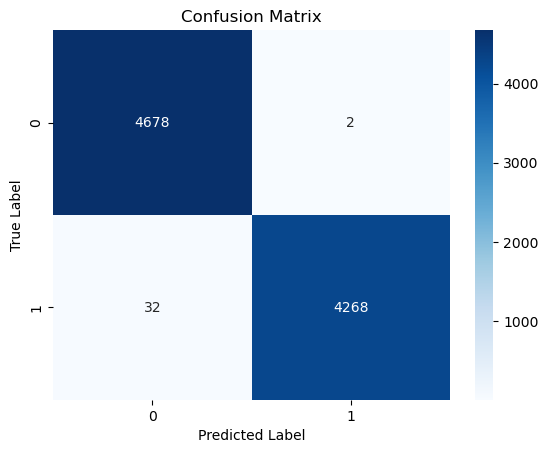

In [32]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

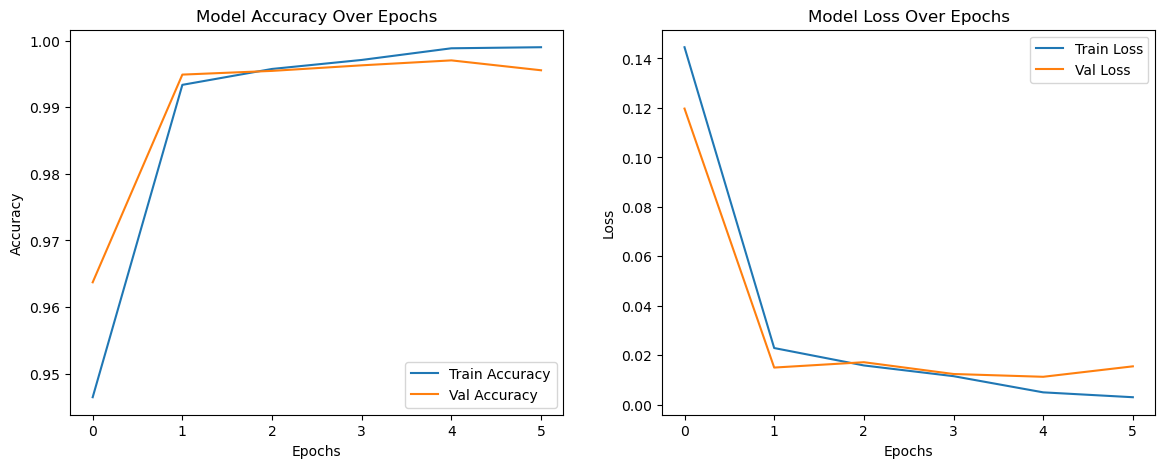

In [33]:
# Accuracy and Loss over Epochs
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()